In [32]:
import os
import requests
import nltk
import pandas as pd
import numpy as np
import seaborn as sns

from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup
from time import sleep, time, strftime
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt

%matplotlib inline

/usr/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [30]:
train_path = 'GeneralData/train'
test_path = 'GeneralData/test'
train_files = []
test_files = []
chat_sents = []

stemmer = PorterStemmer()
afinn = dict(map(lambda words: (words[0], int(words[1])),
         [line.split('\t') for line in open("AFINN/AFINN-111.txt")]))

In [36]:
def correctify(data):
    payload = {'data': data}
    r = requests.get('http://127.0.0.1:1049/checkDocument', params=payload)
    
    with open("atd-log", 'a') as f:
        f.write("[%s]\n" % strftime("%c"))
        f.write("\t%s" % r.text)
        
    soup = BeautifulSoup(r.text, 'xml')
    
    if soup.error:
        all_err = soup.findAll('error')
        for err in all_err:
            s = err.description.findPrevious()
            if not err.type.string == 'grammar':
                if isinstance(err.option, type(err)):
                    if err.option.string and err.precontext.string:
                        beg = data.find(err.precontext.string + s.string) + (data.find(s.string) - data.find(err.precontext.string + s.string))
                        tmp = data[:beg-1] + ' '
                        tmp += err.option.string
                        tmp += data[beg+len(s.string):]
                        data = tmp
                        del tmp
                    elif err.option.string:
                        beg = data.find(s.string)
                        tmp = data[:beg-1] + ' '
                        tmp += err.option.string
                        tmp += data[beg+len(s.string):]
                        data = tmp
                        del tmp
    return data
#
# ----------
#
def AFINN(data):
    score = 0
    for words in nltk.word_tokenize(data):
        try:
            score = score + afinn[words.lower()]
        except KeyError:
            with open("afinn-log", 'a') as f:
                f.write("%s\n" % words)
            continue
    return score
#
# ----------
#
def data_extractor(file, mode):
    tmp=[]

    print("Extracting from: ", file)
    
    f = open(file)
    soup = BeautifulSoup(f, 'xml')

    # data extraction
    predator = soup.find('PREDATOR')
    uid = predator.SCREENNAME.USERNAME.string
    all_post = soup.findAll('POST')
    for post in all_post:
        if mode == "train":
            if post.USERNAME.string == uid:
                if post.BODY.string:
                    tmp.append(post.BODY.string)
        if mode == "test":
            if post.BODY.string:
                tmp.append(post.BODY.string)
            
    f.close()
    
    # spelling correction using ATD
    corrected = []
    print("Correcting: ", file)
    for s in tmp:
        corrected.append(correctify(s))
    #return corrected

    # Sentiment scoring using AFINN & saving to tsv
    print("Calculating sentiment using AFINN:", file)
    for s in corrected:
        sentiment_score = AFINN(s)
        filename = "clean-" + mode + "ing-set-OCSVM.tsv"
        with open(filename, 'a') as f:
            #for x, y in zip(s, sentiment_score):
            f.write("%s\t%d\n" % (s, sentiment_score))
#
# ----------
#
def get_filenames(path):
    list_of_files = []
    for subdir, dirs, files in os.walk(path):
        for file in files:
            file_path = subdir + os.path.sep + file
            list_of_files.append(file_path)
    return list_of_files
#
# ----------
#
def cb(data):
    
    if data:
        global chat_sents
        #lock.acquire()
        #[chat_sents.put(data[i]) for i in range(len(data))]
        chat_sents.extend(data)
        #lock.release()
#
# ----------
#

In [32]:
%%time
train_files = get_filenames(train_path)
test_files = get_filenames(test_path)

CPU times: user 3.33 ms, sys: 0 ns, total: 3.33 ms
Wall time: 988 µs


In [35]:
for file in train_files:
    data_extractor(file, "train")

Extracting from:  GeneralData/train/Pavlov1234.xml
Correcting:  GeneralData/train/Pavlov1234.xml
Calculating sentiment using AFINN: GeneralData/train/Pavlov1234.xml
Extracting from:  GeneralData/train/fredold_2000.xml
Correcting:  GeneralData/train/fredold_2000.xml
Calculating sentiment using AFINN: GeneralData/train/fredold_2000.xml
Extracting from:  GeneralData/train/nickpaul19802000.xml
Correcting:  GeneralData/train/nickpaul19802000.xml
Calculating sentiment using AFINN: GeneralData/train/nickpaul19802000.xml
Extracting from:  GeneralData/train/arthinice.xml
Correcting:  GeneralData/train/arthinice.xml
Calculating sentiment using AFINN: GeneralData/train/arthinice.xml
Extracting from:  GeneralData/train/mjn_523.xml
Correcting:  GeneralData/train/mjn_523.xml
Calculating sentiment using AFINN: GeneralData/train/mjn_523.xml
Extracting from:  GeneralData/train/dble_d1.xml
Correcting:  GeneralData/train/dble_d1.xml
Calculating sentiment using AFINN: GeneralData/train/dble_d1.xml
Extract

In [37]:
for file in test_files:
    data_extractor(file, "test")

Extracting from:  GeneralData/test/sweet_jason002.xml
Correcting:  GeneralData/test/sweet_jason002.xml
Calculating sentiment using AFINN: GeneralData/test/sweet_jason002.xml
Extracting from:  GeneralData/test/red387peter.xml
Correcting:  GeneralData/test/red387peter.xml
Calculating sentiment using AFINN: GeneralData/test/red387peter.xml
Extracting from:  GeneralData/test/sphinx_56_02.xml
Correcting:  GeneralData/test/sphinx_56_02.xml
Calculating sentiment using AFINN: GeneralData/test/sphinx_56_02.xml
Extracting from:  GeneralData/test/sebastian_calif.xml
Correcting:  GeneralData/test/sebastian_calif.xml
Calculating sentiment using AFINN: GeneralData/test/sebastian_calif.xml
Extracting from:  GeneralData/test/schutzea.xml
Correcting:  GeneralData/test/schutzea.xml
Calculating sentiment using AFINN: GeneralData/test/schutzea.xml
Extracting from:  GeneralData/test/stylelisticgrooves.xml
Correcting:  GeneralData/test/stylelisticgrooves.xml
Calculating sentiment using AFINN: GeneralData/te

In [12]:
train = pd.read_csv("clean-training-set-OCSVM.tsv", header=0, delimiter='\t')
train.shape

(10976, 2)

In [13]:
train.columns.values

array(['chat', 'sentiment'], dtype=object)

In [14]:
chat_sents = []
for i in range(train["chat"].size):
    chat_sents.append(train["chat"][i])

In [15]:
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = "english",   \
                             max_features = 50000)

train_data_features = vectorizer.fit_transform(chat_sents)
train_data_features = train_data_features.toarray()

In [16]:
train_data_features.shape

(10976, 4168)

In [19]:
test = pd.read_csv("clean-testing-set-OCSVM.tsv", header=0, delimiter='\t')
test.shape

(25873, 2)

In [20]:
test.columns.values

array(['chat', 'sentiment'], dtype=object)

In [26]:
test_chat_sents = []
for i in range(test["chat"].size):
    test_chat_sents.append(test["chat"][i])

In [27]:
test_data_features = vectorizer.transform(test_chat_sents)
test_data_features = test_data_features.toarray()

In [28]:
clf = svm.OneClassSVM(tol=0.0001, verbose=True,
                      random_state=np.random.seed(0))

clf.fit(train_data_features)

y_pred_train = clf.predict(train_data_features)
y_pred_test = clf.predict(test_data_features)

n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size

[LibSVM]

In [29]:
print("Train accuracy: %0.2f" % (100-((n_error_train/y_pred_train.size)*100)), "%")
print("Test accuracy : %0.2f" % (100-((n_error_test/y_pred_test.size)*100)), "%")

Train accuracy: 49.95 %
Test accuracy : 55.56 %


In [30]:
print(classification_report(test["sentiment"], y_pred_test))

             precision    recall  f1-score   support

        -34       0.00      0.00      0.00         1
        -17       0.00      0.00      0.00         1
        -16       0.00      0.00      0.00         3
        -14       0.00      0.00      0.00         3
        -12       0.00      0.00      0.00         1
        -11       0.00      0.00      0.00         1
        -10       0.00      0.00      0.00         5
         -9       0.00      0.00      0.00         8
         -8       0.00      0.00      0.00        18
         -7       0.00      0.00      0.00        15
         -6       0.00      0.00      0.00        49
         -5       0.00      0.00      0.00        72
         -4       0.00      0.00      0.00       194
         -3       0.00      0.00      0.00       413
         -2       0.00      0.00      0.00       670
         -1       0.05      0.49      0.09      1099
          0       0.00      0.00      0.00     16640
          1       0.08      0.56      0.15   

/usr/lib/python3.5/site-packages/sklearn/metrics/classification.py:1117: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


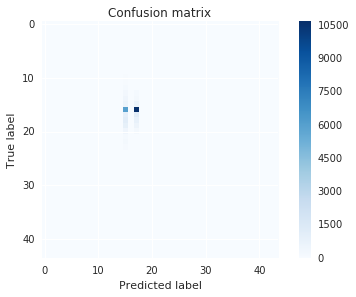

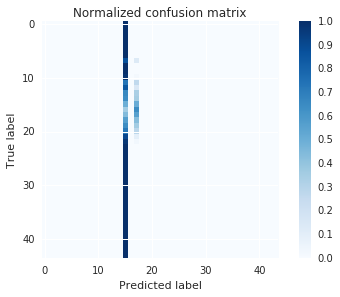

In [33]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cm = confusion_matrix(test["sentiment"], y_pred_test)
np.set_printoptions(precision=2)
#print('Confusion matrix, without normalization')
#print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#print('Normalized confusion matrix')
#print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()